# COMAPRING DIFFERENT MODELS FOR STOCK PREIDCTIONS (FF5, SARIMA, and LSTM)

In this project, I want to do an comparative analysis between a more theoretical approach for stock evaluation versus an entirely data-driven approach. In specific I will be using the many Capital Asset Pricing models, comparing it with SARIMA and then a Neural Network Prediction model.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import plotly.express as px
from IPython.display import Math, Image
from sklearn.linear_model import LinearRegression

# I./ Let us begin with the FF5 model and processing the raw data


Here is the model:

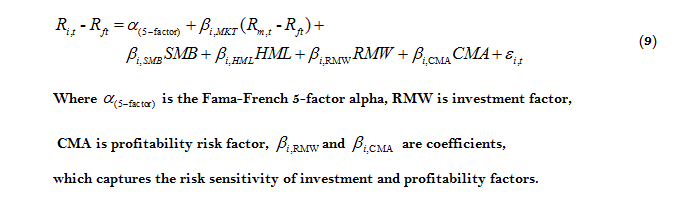

As we can see it is now our job to find the Betas for the three terms. To do so, we need to perform a Multivariate Regression based on the real data. In the real world, people usually find these betas using a 3 month duration to more accurately capture the changing fundamental of the market. For this project I will also use the 3 month period before the test date to predict test date's stock value ( more specifically returns).

## Step 1: in finding the Betas: We import the observation of excess returns on a market portfolio, size, value, profitability, and conservative investment premium.

You can either use something like yahoo finance to write down these information and calculate them yourself, but here I used Professor French's research.

In [221]:
data_url="https://raw.githubusercontent.com/danhuynh23/kraftwerk_testing/main/F-F_Research_Data_5_Factors_2x3_daily%20(1).CSV"
fema_french_5=pd.read_csv(data_url)
fema_french_5['Unnamed: 0']=pd.to_datetime(fema_french_5['Unnamed: 0'],format='%Y%m%d')
fema_french_5.set_index(fema_french_5['Unnamed: 0'],inplace=True)
fema_french_5

,Unnamed: 0,Mkt-RF,SMB,HML,RMW,CMA,RF
Unnamed: 0,,,,,,,
1963-07-01,1963-07-01,-0.67,0.02,-0.35,0.03,0.13,0.012
1963-07-02,1963-07-02,0.79,-0.28,0.28,-0.08,-0.21,0.012
1963-07-03,1963-07-03,0.63,-0.18,-0.10,0.13,-0.25,0.012
1963-07-05,1963-07-05,0.40,0.09,-0.28,0.07,-0.30,0.012
1963-07-08,1963-07-08,-0.63,0.07,-0.20,-0.27,0.06,0.012
...,...,...,...,...,...,...,...
2023-07-25,2023-07-25,0.25,-0.23,-0.79,0.47,-0.41,0.022
2023-07-26,2023-07-26,0.02,0.87,1.03,-0.35,0.65,0.022
2023-07-27,2023-07-27,-0.74,-0.80,0.27,0.38,0.14,0.022


<ipython-input-225-f99ec2fe9d18>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

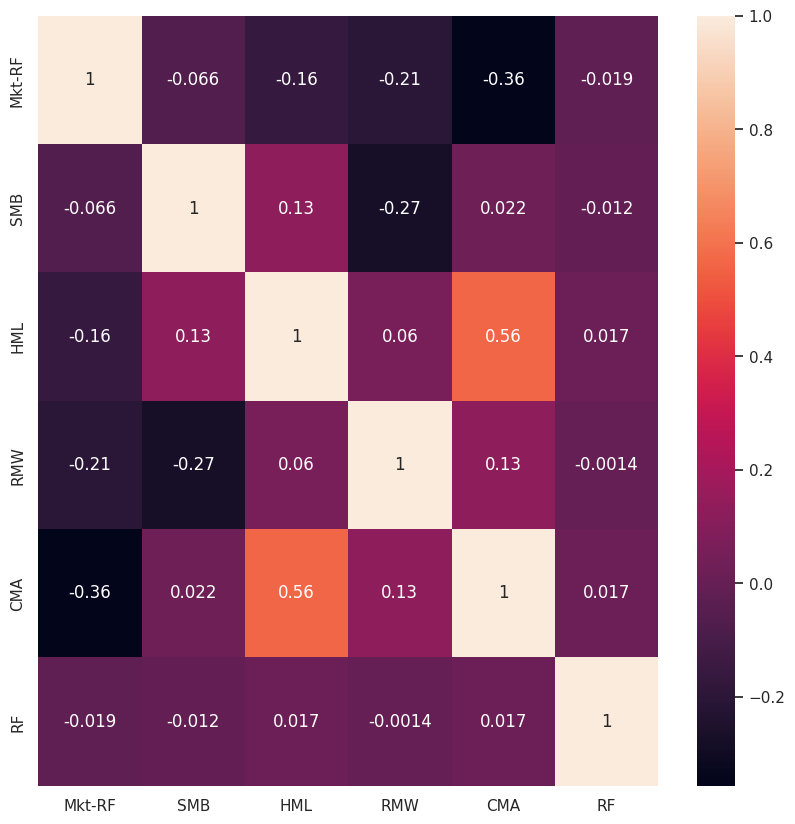

In [225]:
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(fema_french_5.corr(), annot= True)

## Step 2: I choose a smaller time frame to more easily visualize the data. The collab file also used plotly so you can scroll in and out.

In [51]:
start_date="2013-01-01"
end_date="2018-12-31"

In [52]:
mask = (fema_french_5.index > start_date) & (fema_french_5.index <= end_date)
FF5_2000_2018=fema_french_5[mask]

In [150]:
sns.set(rc={'figure.figsize':(40,10)})
fig = px.line(FF5_2000_2018,y=["Mkt-RF","SMB","HML","RMW","CMA","RF"], title='Factors')
fig.show()

## Step 3: Now I am using Alpha Vantage to get the actual data.

In [54]:
api_key = '1822bea789msh219ec7e462e75a0p1d9a2cjsn7596777f7daf'

In [55]:
base_url = 'https://www.alphavantage.co/query'

req_gm = requests.get(
    base_url,
    params={
        "function": "TIME_SERIES_DAILY",
        "symbol": "GM",
        "apikey": api_key,
        "outputsize":"full"

    }
)
data_gm=req_gm.json()
data_gm['Time Series (Daily)']
result_gm = pd.DataFrame.from_dict(data_gm['Time Series (Daily)'], orient= 'index')
result_gm.index =  pd.to_datetime(result_gm.index, format='%Y-%m-%d')
result_gm['4. close']=pd.to_numeric(result_gm['4. close'])

In [56]:
result_gm

,1. open,2. high,3. low,4. close,5. volume
2023-12-21,35.8100,36.3150,35.6900,36.255,18213689
2023-12-20,35.7300,36.4000,35.4600,35.470,16585372
2023-12-19,35.5100,35.9950,35.3700,35.870,11863081
2023-12-18,35.7800,36.1550,35.4300,35.440,18151795
2023-12-15,36.3000,36.4900,35.6150,35.730,34158069
...,...,...,...,...,...
2010-11-24,33.7300,33.8000,33.2200,33.480,26138000
2010-11-23,33.9500,33.9900,33.1900,33.250,31170200
2010-11-22,34.2000,34.4800,33.8100,34.080,36650600
2010-11-19,34.1500,34.5000,33.1100,34.260,107842000


Flipping the data beacause it was backward

In [57]:
result_gm=result_gm.iloc[::-1]
result_gm

,1. open,2. high,3. low,4. close,5. volume
2010-11-18,35.0000,35.9900,33.8900,34.190,457044300
2010-11-19,34.1500,34.5000,33.1100,34.260,107842000
2010-11-22,34.2000,34.4800,33.8100,34.080,36650600
2010-11-23,33.9500,33.9900,33.1900,33.250,31170200
2010-11-24,33.7300,33.8000,33.2200,33.480,26138000
...,...,...,...,...,...
2023-12-15,36.3000,36.4900,35.6150,35.730,34158069
2023-12-18,35.7800,36.1550,35.4300,35.440,18151795
2023-12-19,35.5100,35.9950,35.3700,35.870,11863081
2023-12-20,35.7300,36.4000,35.4600,35.470,16585372


## Step 4: Calculating the returns as CAPM models take E[R]

In [58]:
result_gm['returns'] = (result_gm['4. close'] - result_gm['4. close'].shift(1))/result_gm['4. close'].shift(1)
mask_stock=(result_gm.index > start_date) & (result_gm.index <= end_date)
GM_2013_2018=result_gm[mask_stock]

<ipython-input-58-57c2d4bb940b>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [226]:
fig_2 = px.line(GM_2013_2018,y=["4. close"], title='GM')
fig_2.show()

In [60]:
fig_3= px.line(GM_2013_2018,y=["returns"], title='GM')
fig_3.show()

In [61]:
FF5=FF5_2000_2018.copy()
FF5['GM']=GM_2013_2018['returns']
FF5

,Unnamed: 0,Mkt-RF,SMB,HML,RMW,CMA,RF,GM
Unnamed: 0,,,,,,,,
2013-01-02,2013-01-02,2.62,0.12,0.38,-0.64,0.01,0.000,0.010406
2013-01-03,2013-01-03,-0.14,0.14,0.04,0.18,0.27,0.000,0.023687
2013-01-04,2013-01-04,0.55,0.18,0.36,-0.36,0.24,0.000,0.001341
2013-01-07,2013-01-07,-0.31,-0.12,-0.35,-0.10,-0.14,0.000,-0.006698
2013-01-08,2013-01-08,-0.27,0.04,0.00,-0.16,0.10,0.000,-0.009777
...,...,...,...,...,...,...,...,...
2018-12-24,2018-12-24,-2.55,0.92,-0.48,-0.33,-0.33,0.011,-0.018496
2018-12-26,2018-12-26,5.06,-0.20,-1.02,-0.21,-1.08,0.011,0.035527
2018-12-27,2018-12-27,0.78,-0.71,-0.12,-0.14,0.10,0.011,0.013126


## Step 5 :We now perform regression to find the Betas for 2013-2018.

In [62]:
y=FF5['GM']
X=FF5[['Mkt-RF','SMB','HML','RMW','CMA','RF']]
X=sm.add_constant(X)
FF5_GM=sm.OLS(y,X).fit()
print(FF5_GM.summary())

                            OLS Regression Results                            
Dep. Variable:                     GM   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     126.4
Date:                Thu, 21 Dec 2023   Prob (F-statistic):          1.60e-129
Time:                        21:40:37   Log-Likelihood:                 4408.8
No. Observations:                1510   AIC:                            -8804.
Df Residuals:                    1503   BIC:                            -8766.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.000     -0.941      0.3

In [63]:
newmask = (FF5.index > "2015-9-30") & (FF5.index <= "2015-12-31")
FF5_3M=FF5[newmask]

In [64]:
y=FF5_3M['GM']
X_FF5=FF5_3M[['Mkt-RF','SMB','HML','RMW','CMA','RF']]
X_FF5=sm.add_constant(X_FF5)
X_FF3=FF5_3M[['Mkt-RF','SMB','HML','RF']]
X_FF3=sm.add_constant(X_FF3)
X_CAPM=FF5_3M[['Mkt-RF','RF']]
X_CAPM=sm.add_constant(X_CAPM)

FF5_GM_3M=sm.OLS(y,X_FF5).fit()
FF3_GM_3M=sm.OLS(y,X_FF3).fit()
CAPM_GM_3M=sm.OLS(y,X_CAPM).fit()

## Step 6: Comparing the various CAPM models


In [65]:
models=["FF5","FF3","CAPM"]
R2ADJ=[FF5_GM_3M.rsquared_adj,FF3_GM_3M.rsquared_adj,CAPM_GM_3M.rsquared_adj]
comparision = pd.DataFrame({'models':models, 'R2ADJ':R2ADJ})
comparision

,models,R2ADJ
0,FF5,0.339004
1,FF3,0.321264
2,CAPM,0.318822


In [66]:
print(FF5_GM_3M.summary())

                            OLS Regression Results                            
Dep. Variable:                     GM   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     7.462
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           1.84e-05
Time:                        21:40:37   Log-Likelihood:                 194.05
No. Observations:                  64   AIC:                            -376.1
Df Residuals:                      58   BIC:                            -363.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.900      0.3

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning:

divide by zero encountered in double_scalars



We can see that FF5 is the best model out of the three.

## Step 7: Now we can use FF5 to generate predictions about the future.

In [67]:
test_mask=(FF5.index > "2015-12-31")
Test=FF5[test_mask]

In [68]:
fig_5 = px.line(Test,y=["Mkt-RF","SMB","HML","RMW","CMA","RF"], title='Factors')
fig_5.show()

In [69]:
Predictions=0.0014+0.0098*Test['Mkt-RF']-0.0011*Test['SMB']+0.0021*Test['HML']+0.0089*Test['RMW']+0.0021*Test['CMA']

In [70]:
Predictions

Unnamed: 0
2016-01-04   -0.008257
2016-01-05    0.003957
2016-01-06   -0.010158
2016-01-07   -0.016908
2016-01-08   -0.006639
                ...   
2018-12-24   -0.029240
2018-12-26    0.044929
2018-12-27    0.008537
2018-12-28   -0.002592
2018-12-31    0.008334
Length: 754, dtype: float64

In [71]:
Test['FF5_prediction']=Predictions

<ipython-input-71-90b53cff79d8>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [72]:
Test['Gap']=abs(Test['FF5_prediction']-Test['GM'])

<ipython-input-72-0363d5a7ad9c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Step 8: Comparing our predictions with the truth

In [227]:
fig_6 = px.line(Test,y=["GM","FF5_prediction"], title='FF5 Vs Truth')
fig_6.show()

Here we are not actually predicting stock price directly but stock returns

Although it might be difficult to see, the model get worst over time as the underlying business is changing. I also picked a time of low interest rate so FF5 alone needs constant updating which is why Betas are listed as 3 Months, because it is only valid for that amount of time.

In [228]:
fig_7 = px.line(Test,y=["Gap"], title='Gap')
fig_7.show()

## Step 9: I created a simple function as doing all of this is quite tedious. It is a pipeline in a way.

In [229]:
import pandas as pd
import requests
from sklearn.linear_model import LinearRegression
import datetime

def FF5(ticker):
  data_url="https://raw.githubusercontent.com/danhuynh23/kraftwerk_testing/main/F-F_Research_Data_5_Factors_2x3_daily%20(1).CSV"
  api_key = '1822bea789msh219ec7e462e75a0p1d9a2cjsn7596777f7daf'
  fema_french_5=pd.read_csv(data_url)
  fema_french_5['Unnamed: 0']=pd.to_datetime(fema_french_5['Unnamed: 0'],format='%Y%m%d')
  fema_french_5.set_index(fema_french_5['Unnamed: 0'],inplace=True)

  base_url = 'https://www.alphavantage.co/query'

  req_gm = requests.get(
      base_url,
      params={
          "function": "TIME_SERIES_DAILY",
          "symbol": ticker,
          "apikey": api_key,
          "outputsize":"full"

      }
  )
  data_gm=req_gm.json()
  result_gm = pd.DataFrame.from_dict(data_gm['Time Series (Daily)'], orient= 'index')
  result_gm.index =  pd.to_datetime(result_gm.index, format='%Y-%m-%d')
  result_gm['4. close']=pd.to_numeric(result_gm['4. close'])
  result_gm=result_gm.iloc[::-1]
  result_gm['returns'] = (result_gm['4. close'] - result_gm['4. close'].shift(1))/result_gm['4. close'].shift(1)



  a=result_gm.index[-1]
  c=fema_french_5.index[-1]
  b = c - datetime.timedelta(weeks=12)
  result_gm=result_gm.loc[(result_gm.index >= b)&(result_gm.index <c)]
  fema_french_5=fema_french_5.loc[(fema_french_5.index>=b)&(fema_french_5.index<c)]
  FF5=fema_french_5
  print("Start date"+str(b))
  print("End date"+str(c))

  FF5['GM']=result_gm['returns']
  FF5['excess_GM']=(FF5['GM']-FF5['RF'])
  y=FF5['excess_GM']
  X=FF5[['Mkt-RF','SMB','HML','RMW','CMA']]
  FF5_GM=LinearRegression()
  FF5_GM.fit(X,y)

  coef=FF5_GM.coef_
  result_values=np.append(coef,[FF5_GM.intercept_])
  result_name=["Alpha","Mkt-RF","SMB","HML","RMW","CMA"]
  result = pd.DataFrame({'Betas':result_name, 'values':result_values})
  return result

In [230]:
FF5("MSFT")

Start date2023-05-08 00:00:00
End date2023-07-31 00:00:00


,Betas,values
0,Alpha,0.012412
1,Mkt-RF,-0.000872
2,SMB,-0.004513
3,HML,0.009114
4,RMW,-0.012736
5,CMA,-0.021448


You can use these 3-M beta to predict stock movement with an updated FF5 table.

# II./ Now moving onto SARIMA.


## Step 1: Calling the data again

In [77]:
!pip install pmdarima
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose as sd

In [105]:
GM_2013_2018

,1. open,2. high,3. low,4. close,5. volume,returns
2013-01-02,29.4100,29.5000,28.6300,29.13,15605900,0.010406
2013-01-03,29.0500,30.2300,28.8400,29.82,22903800,0.023687
2013-01-04,29.7400,29.8600,29.2300,29.86,8066600,0.001341
2013-01-07,29.6400,29.8600,29.3000,29.66,8385300,-0.006698
2013-01-08,29.6600,29.8500,29.0500,29.37,10435200,-0.009777
...,...,...,...,...,...,...
2018-12-24,32.6500,32.9400,32.2500,32.37,9110187,-0.018496
2018-12-26,32.5800,33.5300,31.4600,33.52,12490397,0.035527
2018-12-27,33.0700,34.0000,32.3900,33.96,13652980,0.013126
2018-12-28,33.9500,34.7300,33.6800,33.92,8677963,-0.001178


In [106]:
GM_2013_2018_SARIMA=pd.DataFrame(GM_2013_2018['4. close'])

In [107]:
GM_2013_2016_SARIMA=GM_2013_2018_SARIMA

## Step 2: Then sampling the data via months

In [137]:
monthly_mean = GM_2013_2018_SARIMA['4. close'].resample('W').mean()
monthly_data = monthly_mean.to_frame()

In [138]:
monthly_data

,4. close
2013-01-06,29.603333
2013-01-13,29.960000
2013-01-20,29.802000
2013-01-27,28.762500
2013-02-03,28.296000
...,...
2018-12-09,36.340000
2018-12-16,35.000000
2018-12-23,34.348000
2018-12-30,33.442500


from matplotlib import pyplot as plt
monthly_data['4. close'].plot(kind='hist', bins=20, title='4. close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
monthly_data['4. close'].plot(kind='line', figsize=(8, 4), title='4. close')
plt.gca().spines[['top', 'right']].set_visible(False)

## Step 3: Checking and decomposing the newly resampled data

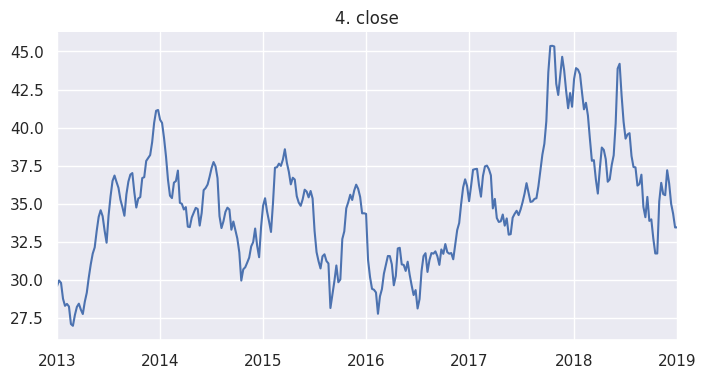

In [149]:
monthly_data['4. close'].plot(kind='line', figsize=(8, 4), title='4. close')
plt.gca().spines[['top', 'right']].set_visible(False)

In [139]:
a="2016-01-01"
train=monthly_data[monthly_data.index<a]

In [140]:
train.tail()

,4. close
2015-11-29,36.2525
2015-12-06,35.9820
2015-12-13,35.4480
2015-12-20,34.3700
2015-12-27,34.3750


In [141]:
test=monthly_data[monthly_data.index>=a]

In [142]:
test.tail()

,4. close
2018-12-09,36.3400
2018-12-16,35.0000
2018-12-23,34.3480
2018-12-30,33.4425
2019-01-06,33.4500


<Figure size 3000x1200 with 0 Axes>

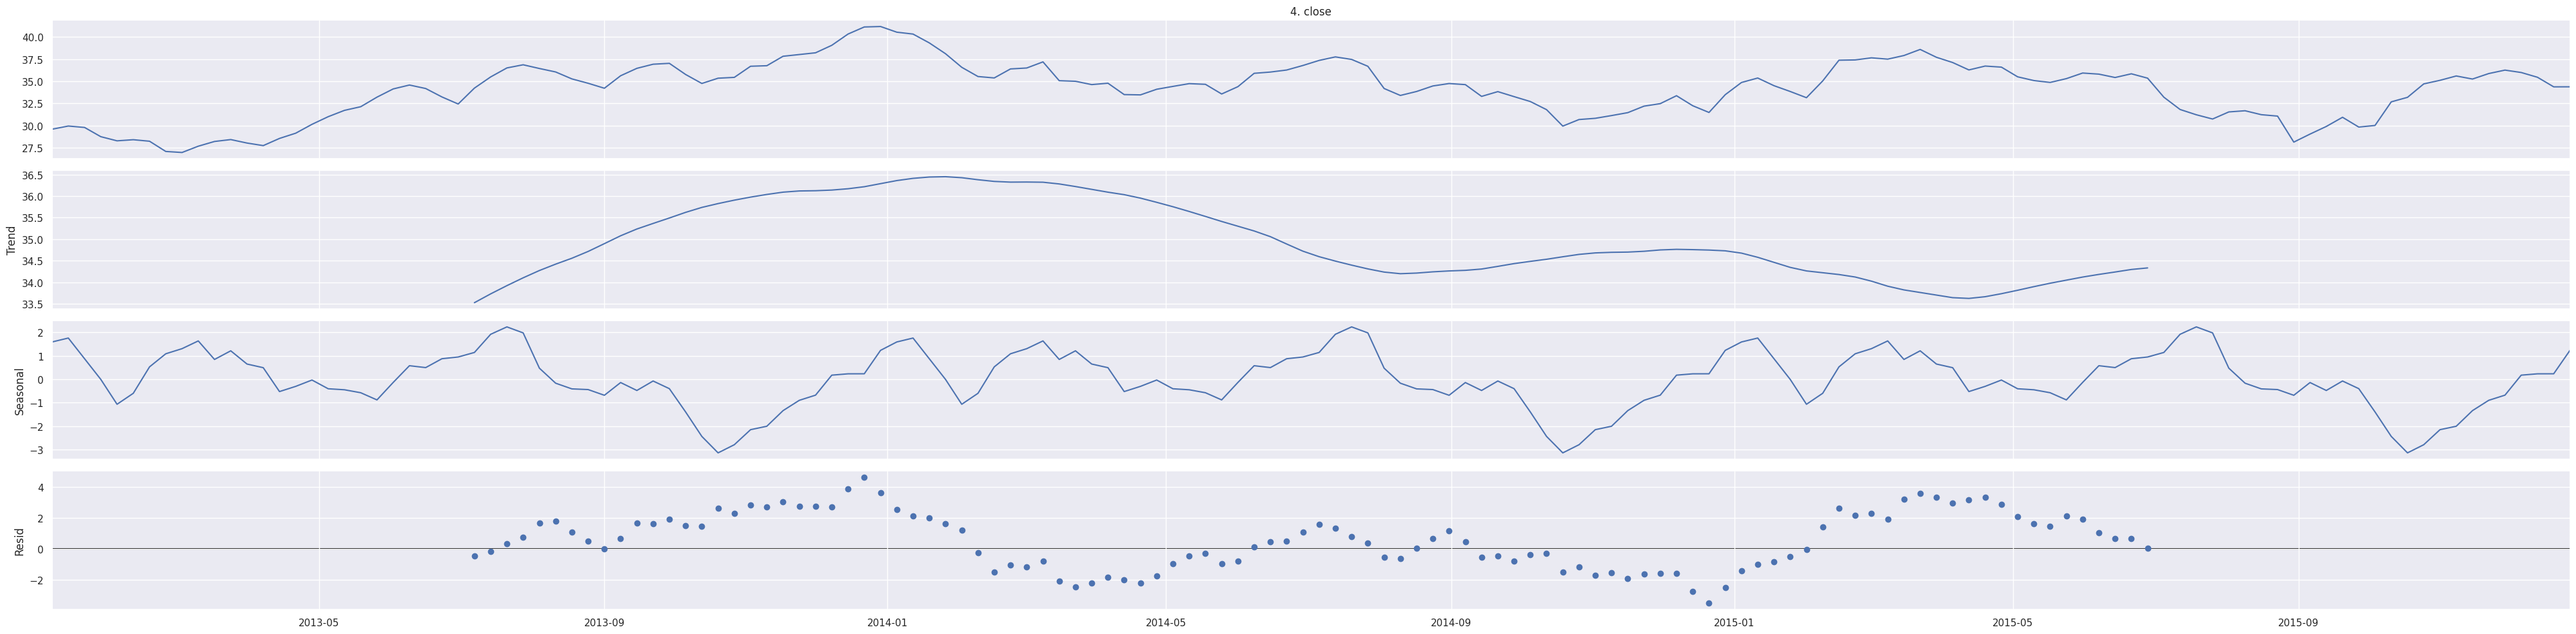

In [143]:
plt.figure(figsize=(30,12))
decomposed_series = sd(train['4. close'],model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)
decomposed_series.plot()
plt.show()

We can see that it is not very seasonal, so our predictions might be very off-based.

## Step 4: Using auto_arima to select the best autoregression paramters

In [144]:
model = pm.auto_arima(train,
                      start_p = 1,
                      max_p = 3,
                      start_d = 0,
                      max_d = 3,
                      start_q = 0,
                      max_q = 3,
                      start_P = 1,
                      start_D = 1,
                      start_Q = 1,
                      max_P=2,
                      max_D=1,
                      max_Q=2,
                      m = 12)

In [145]:
predictions = pd.Series(model.predict(n_periods = len(test)))
predictions.index = test.index

In [146]:
test['predictions']=predictions

<ipython-input-146-a4ffa1b43cf9>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [147]:
test

,4. close,predictions
2016-01-03,34.3375,34.348020
2016-01-10,31.3060,34.311941
2016-01-17,30.1820,34.274846
2016-01-24,29.4125,34.239469
2016-01-31,29.3500,34.206621
...,...,...
2018-12-09,36.3400,33.858050
2018-12-16,35.0000,33.858050
2018-12-23,34.3480,33.858050
2018-12-30,33.4425,33.858050


In [148]:
fig_8 = px.line(test,y=["4. close","predictions"], title='SARIMA Vs Truth')
fig_8.show()

The model performed pretty teribly due to stock not being a seasonal thing

# III./ Finally let try Neural Network forcasting.

## Step 1: Setting the data

For the model, I will use a Long Short-Term Memory (LSTM) model.

In [154]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [153]:
train

,4. close
2013-01-06,29.603333
2013-01-13,29.960000
2013-01-20,29.802000
2013-01-27,28.762500
2013-02-03,28.296000
...,...
2015-11-29,36.252500
2015-12-06,35.982000
2015-12-13,35.448000
2015-12-20,34.370000


Here I am using a window side of 5, which equates to 5 days of trading.

In [158]:
def TS_df_to_X_y(df, mem):
  np_arr=df.to_numpy()
  X=[]
  y=[]
  for i in range(len(np_arr)-mem):
    row=[[a] for a in np_arr[i:i+5]]
    X.append(row)
    label= np_arr[i+5]
    y.append(label)
  return np.array(X) , np.array(y)

In [163]:
result_gm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3295 entries, 2010-11-18 to 2023-12-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   1. open    3295 non-null   object 
 1   2. high    3295 non-null   object 
 2   3. low     3295 non-null   object 
 3   4. close   3295 non-null   float64
 4   5. volume  3295 non-null   object 
 5   returns    3294 non-null   float64
dtypes: float64(2), object(4)
memory usage: 180.2+ KB


In [162]:
mem=5
X,y= TS_df_to_X_y(result_gm["4. close"],mem)
X.shape, y.shape

((3290, 5, 1), (3290,))

Setting up the Train, Val, Test Split

In [166]:
X_train, y_train =X[:2000],y[:2000]
X_val, y_val =X[2000:2500],y[2000:2500]
X_test, y_test=X[2500:],y[2500:]

## Step 2: Setting up the model

In [192]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [203]:
X_train

array([[[34.19],
        [34.26],
        [34.08],
        [33.25],
        [33.48]],

       [[34.26],
        [34.08],
        [33.25],
        [33.48],
        [33.8 ]],

       [[34.08],
        [33.25],
        [33.48],
        [33.8 ],
        [33.8 ]],

       ...,

       [[32.  ],
        [32.65],
        [33.13],
        [33.54],
        [36.59]],

       [[32.65],
        [33.13],
        [33.54],
        [36.59],
        [36.47]],

       [[33.13],
        [33.54],
        [36.59],
        [36.47],
        [36.03]]])

In [176]:
model1= Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 64)                16896     
                                                                 
 dense_9 (Dense)             (None, 8)                 520       
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [209]:
cp=ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

## Step 3: Fit and Predict

In [210]:
model1.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10,callbacks=[cp])

Epoch 1/10
63/63 [==============================] - 7s 68ms/step - loss: 110.9571 - root_mean_squared_error: 10.5336 - val_loss: 31.9960 - val_root_mean_squared_error: 5.6565
Epoch 2/10
63/63 [==============================] - 4s 59ms/step - loss: 24.5812 - root_mean_squared_error: 4.9579 - val_loss: 12.8441 - val_root_mean_squared_error: 3.5839
Epoch 3/10
63/63 [==============================] - 5s 84ms/step - loss: 6.9315 - root_mean_squared_error: 2.6328 - val_loss: 2.5800 - val_root_mean_squared_error: 1.6062
Epoch 4/10
63/63 [==============================] - 4s 60ms/step - loss: 2.6770 - root_mean_squared_error: 1.6361 - val_loss: 1.6839 - val_root_mean_squared_error: 1.2977
Epoch 5/10
63/63 [==============================] - 0s 5ms/step - loss: 1.3705 - root_mean_squared_error: 1.1707 - val_loss: 1.7650 - val_root_mean_squared_error: 1.3285
Epoch 6/10
63/63 [==============================] - 0s 5ms/step - loss: 1.5285 - root_mean_squared_error: 1.2363 - val_loss: 2.2344 - val_ro

In [211]:
model1= load_model('model1/')

In [216]:
test_predictions=model1.predict(X_test).flatten()

25/25 [==============================] - 0s 5ms/step


In [218]:
result=pd.DataFrame({"predictions":test_predictions,"truth":y_test})
result

,predictions,truth
0,35.057354,34.550
1,34.983593,35.350
2,35.641361,35.240
3,35.587811,37.140
4,36.813869,37.470
...,...,...
785,35.905212,35.730
786,35.771172,35.440
787,35.841862,35.870
788,36.314106,35.470


In [219]:
fig_9 = px.line(result,y=["predictions","truth"], title='LTSM Vs Truth')
fig_9.show()

We can see that the model fit the test data very very, although there is a section between 50 and 350 which it just became flat.

# IV./ In Conclusion:



The LSTM is clearly the best predictor for stocks, followed by the FF5 and then SARIMA. The ability to predcit the movement of stock, even if you are predicitng over its value can be very favorable in deciding to purchase an option as their price is depent on the volitility of the stock. With the out from LSTM you can find the standard deviation of the stock in the future and utilize the Black and Scholes model to invest in calls and puts.

Here is the Black and Scholes formula:

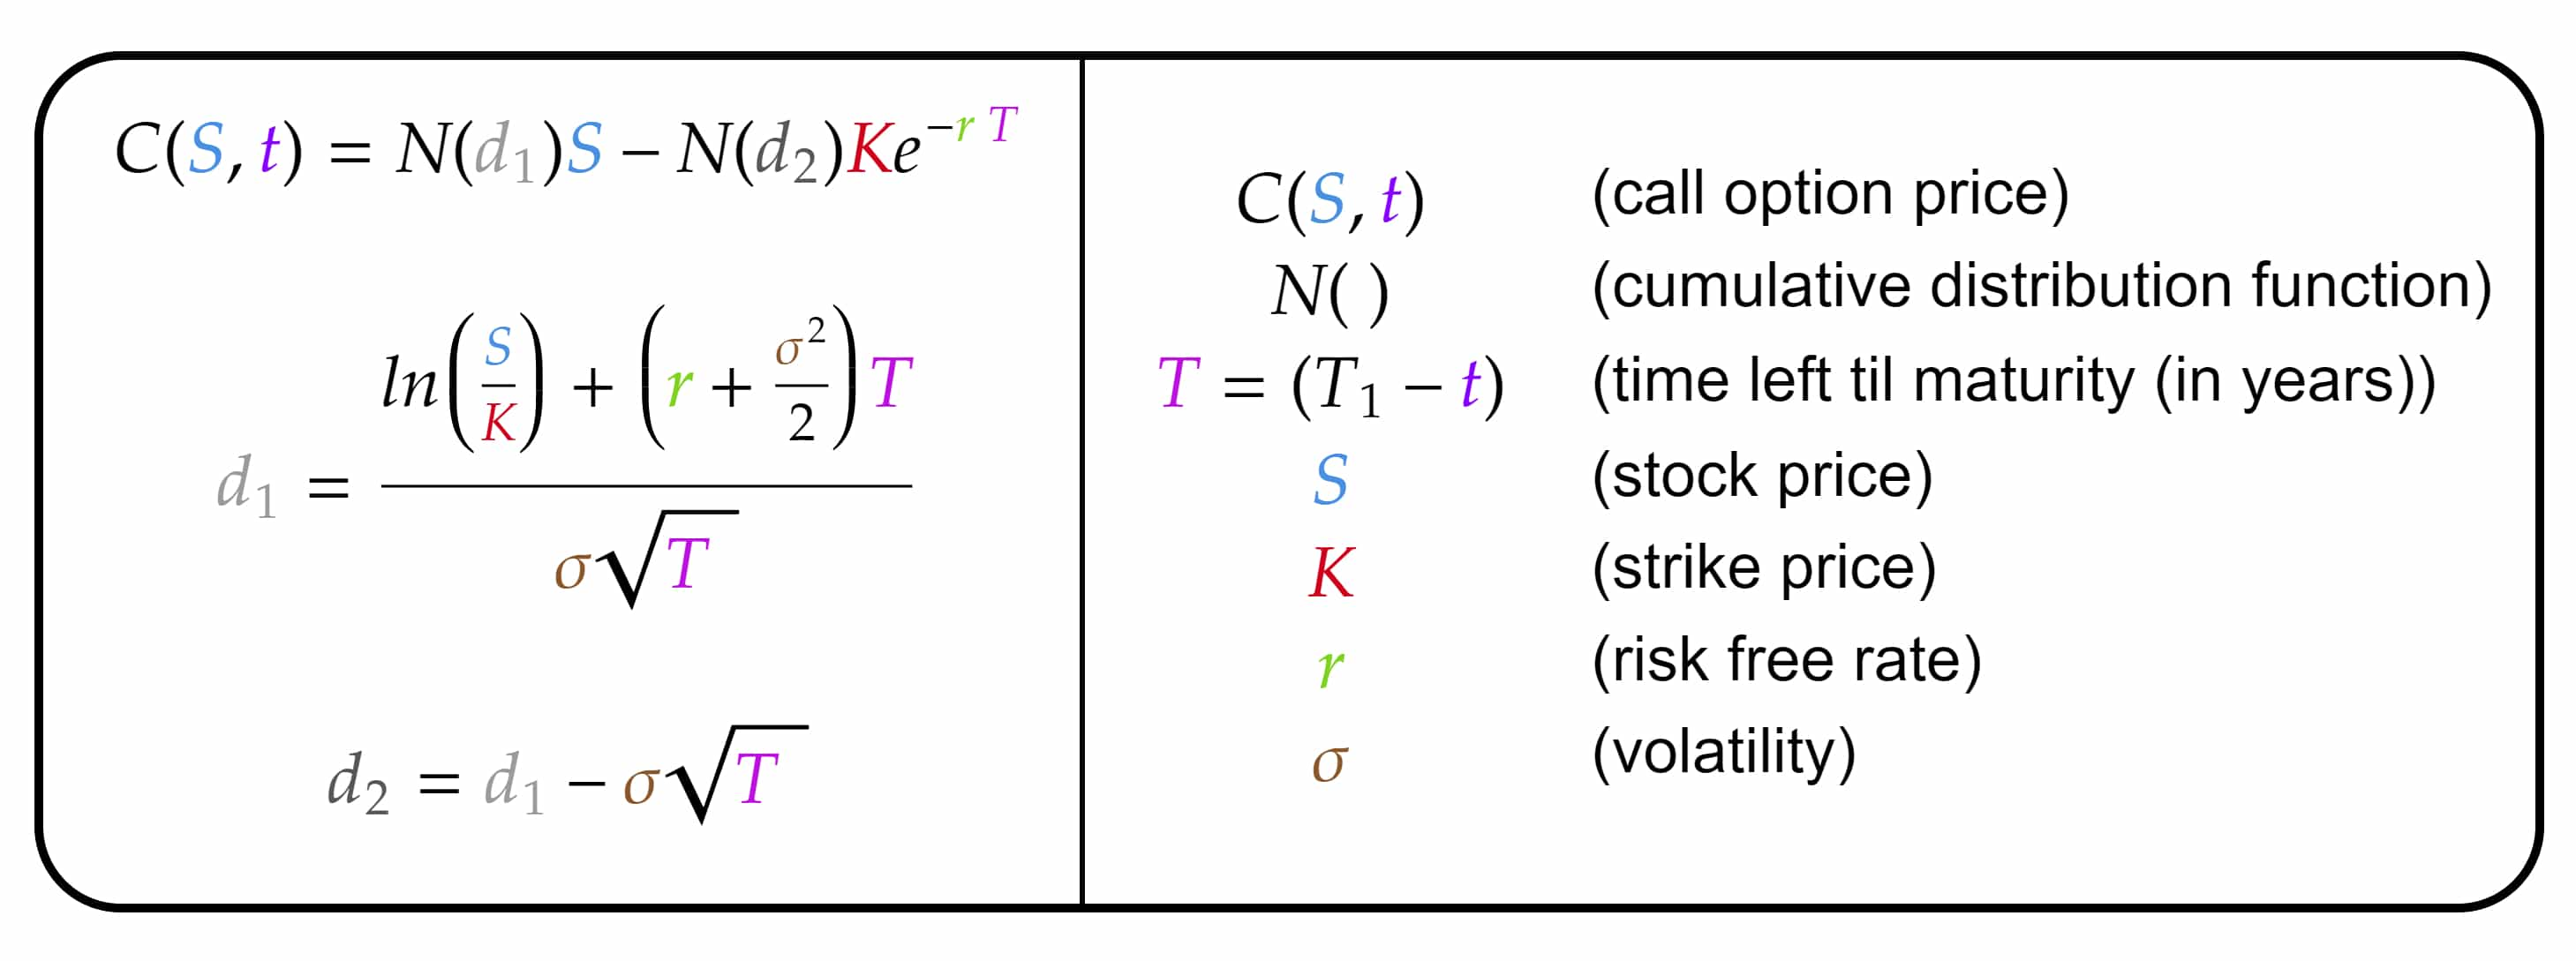

